### Adapt inverse kinematics to ground locomotion data

This notebook contains the process to compute the inverse kinematics from the 3D pose measured in the flytracker setup. 

In [14]:
%load_ext autoreload
%load_ext blackcellmagic
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import glob
import pickle
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

import matplotlib
matplotlib.pyplot.set_loglevel (level = 'warning')

from nmf_ik.utils import dict_to_nparray_pose, save_file, interpolate_signal, calculate_nmf_size
from nmf_ik.data import BOUNDS, NMF_SIZE, NMF_TEMPLATE, INITIAL_ANGLES
from nmf_ik.leg_inverse_kinematics import LegInverseKinematics
from nmf_ik.kinematic_chain import KinematicChainYPR
from nmf_ik.visualization import plot_3d_points, animate_3d_points

DATA_PATH = Path(
    "../data/data_flytracker"
)

# Next two data come from the paper
aligned_pose_pp = pd.read_pickle(
    DATA_PATH / "aligned_df3dpp.pkl"
)

# joint_angles_pp = pd.read_pickle(
#     DATA_PATH / "joint_angles__210902_PR_Fly1.pkl"
# )

ANGLES = [
    "ThC_yaw",
    "ThC_pitch",
    "ThC_roll",
    "CTr_pitch",
    "CTr_roll",
    "FTi_pitch",
    "TiTa_pitch",
]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Dictionary conversion

In [15]:
# Aligned pose now in a nested dictionary format. -> dictionary[leg_name][key_point_name][raw_pos_aligned]
# My package is using numpy arrays, so we convert the pose dictionary into a compatible format

print(aligned_pose_pp.keys())

converted_aligned_pose = {}

for leg_name, leg_pose_data in aligned_pose_pp.items():
    if leg_name == 'meta':
        continue
#     print(leg_pose_data.keys())
    converted_aligned_pose[leg_name] = dict_to_nparray_pose(
        leg_pose_data, claw_is_end_effector=True
    )

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg', 'meta'])


In [16]:
print(converted_aligned_pose.keys())

converted_aligned_pose['RF_leg'].shape # timestep, key points, coordinates (x,y,z)

dict_keys(['RF_leg', 'RM_leg', 'RH_leg', 'LF_leg', 'LM_leg', 'LH_leg'])


(31, 5, 3)

In [17]:
# let's save the new dictionary
save_file(DATA_PATH / 'pose3d_aligned.pkl', converted_aligned_pose)

In [18]:
# We will use these configs for the 3D plotting
KEY_POINTS_DICT = {
    "LH": (np.arange(25, 30), "solid"),
    "RH": (np.arange(10, 15), "solid"),
    "LM": (np.arange(20, 25), "solid"),
    "RM": (np.arange(5, 10), "solid"),
    "LF": (np.arange(15, 20), "solid"),
    "RF": (np.arange(0, 5), "solid"),
}

KEY_POINTS_DICT2 = {
    "LH": (np.arange(45, 54), ":"),
    "RH": (np.arange(18, 27), ":"),
    "LM": (np.arange(36, 45), ":"),
    "RM": (np.arange(9, 18), ":"),
    "LF": (np.arange(27, 36), ":"),
    "RF": (np.arange(0, 9), ":"),
}


In [19]:
# Plot the aligned pose
points_aligned_all = np.concatenate(
    (
        converted_aligned_pose["RF_leg"],
        converted_aligned_pose["LF_leg"],
        converted_aligned_pose["RM_leg"],
        converted_aligned_pose["LM_leg"],
        converted_aligned_pose["RH_leg"],
        converted_aligned_pose["LH_leg"],
    ),
    axis=1,
)

for t in range(points_aligned_all.shape[0]):
    for azim, elev in [(0,0),(90,0),(0,90)]:

        fig = plt.figure(dpi=100)
        ax3d = fig.add_subplot(projection='3d')
        ax3d.view_init(azim=azim, elev=elev)

        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')

        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            export_path=DATA_PATH / 'aligned_pose' / f'azim_{azim}_elev_{elev}_{t}.png',
            t=t
        )


        plt.close()

## Using sequential Inverse Kinematics
* Interpolate the data

In [20]:
# Interpolate the aligned pose:
intpd_pose = {}
for body_part, bp_array in converted_aligned_pose.items():
    print(bp_array.shape)
    # I don't know what the old time step is, so I  just guessed it.
    inpd_array = interpolate_signal(bp_array, 1./60, 5e-3)
    print(inpd_array.shape)
    intpd_pose[body_part] = inpd_array

(31, 5, 3)
(104, 5, 3)
(31, 5, 3)
(104, 5, 3)
(31, 5, 3)
(104, 5, 3)
(31, 5, 3)
(104, 5, 3)
(31, 5, 3)
(104, 5, 3)
(31, 5, 3)
(104, 5, 3)


In [21]:

# Now we converted the aligned pose from nested dictionary to numpy arrays.
# Let's start using seq_ik

# Step 1: alignment - already done using DF3DPP so we can skip

"""
align = AlignPose(DATA_PATH, pts2align=PTS2ALIGN, nmf_template=NMF_TEMPLATE)
aligned_pos = align.align_pose(
    save_pose_file=True,
)
"""

# Step 2. calculation of joint angles
# We are defining a set of initial seeds for the IK optimization

INITIAL_ANGLES_LOCOMOTION = {
    "RF": {
        # Base ThC yaw pitch CTr pitch
        "stage_1": np.array([0.0, 0.45, -0.07, -2.14]),
        # Base ThC yaw pitch roll CTr pitch CTr roll
        "stage_2": np.array([0.0, 0.45, -0.07, -0.32, -2.14, 1.4]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch
        "stage_3": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0]),
        # Base ThC yaw pitch roll CTr pitch CTr roll FTi pitch TiTa pitch
        "stage_4": np.array([0.0, 0.45, -0.07, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LF": {
        "stage_1": np.array([0.0, -0.45, -0.07, -2.14]),
        "stage_2": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, -0.07, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RM": {
        "stage_1": np.array([0.0, 0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, 0.45, 0.37, -0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.45, 0.37, -0.32, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.45, 0.37, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LM": {
        "stage_1": np.array([0.0, -0.45, 0.37, -2.14]),
        "stage_2": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, 0.37, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "RH": {
        "stage_1": np.array([0.0, 0.45, 0.07, -2.14]),
        "stage_2": np.array([0.0, 0.45, 0.07, -0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, 0.45, 0.07, -0.32, -2.14, -1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, 0.45, 0.07, -0.32, -2.14, -1.25, 1.48, 0.0, 0.0]),
    },

    "LH": {
        "stage_1": np.array([0.0, -0.45, 0.07, -2.14]),
        "stage_2": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.4]),
        "stage_3": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.25, 1.48, 0.0]),
        "stage_4": np.array([0.0, -0.45, 0.07, 0.32, -2.14, 1.25, 1.48, 0.0, 0.0]),
    },

    "head": np.array([0, -0.17, 0]),  #  none, roll, pitch, yaw
}

# We define a template to create the kinematic chain
# The length of chain comes from the size calculated from the template

TEMPLATE_NMF_LOCOMOTION = {
    'RF_Coxa': np.array([0.35, -0.27, 0.400]),
    'RF_Femur': np.array([0.35, -0.27, -0.025]),
    'RF_Tibia': np.array([0.35, -0.27, -0.731]),
    'RF_Tarsus': np.array([0.35, -0.27, -1.249]),
    'RF_Claw': np.array([0.35, -0.27, -1.912]),
    'LF_Coxa': np.array([0.35, 0.27, 0.400]),
    'LF_Femur': np.array([0.35, 0.27, -0.025]),
    'LF_Tibia': np.array([0.35, 0.27, -0.731]),
    'LF_Tarsus': np.array([0.35, 0.27, -1.249]),
    'LF_Claw': np.array([0.35, 0.27, -1.912]),
    'RM_Coxa': np.array([0, -0.125, 0]),
    'RM_Femur': np.array([0, -0.125, -0.182]),
    'RM_Tibia': np.array([0, -0.125, -0.965]),
    'RM_Tarsus': np.array([0, -0.125, -1.633]),
    'RM_Claw': np.array([0, -0.125, -2.328]),
    'LM_Coxa': np.array([0, 0.125, 0]),
    'LM_Femur': np.array([0, 0.125, -0.182]),
    'LM_Tibia': np.array([0, 0.125, -0.965]),
    'LM_Tarsus': np.array([0, 0.125, -1.633]),
    'LM_Claw': np.array([0, 0.125, -2.328]),
    'RH_Coxa': np.array([-0.215, -0.087, -0.073]),
    'RH_Femur': np.array([-0.215, -0.087, -0.272]),
    'RH_Tibia': np.array([-0.215, -0.087, -1.108]),
    'RH_Tarsus': np.array([-0.215, -0.087, -1.793]),
    'RH_Claw': np.array([-0.215, -0.087, -2.588]),
    'LH_Coxa': np.array([-0.215, 0.087, -0.073]),
    'LH_Femur': np.array([-0.215, 0.087, -0.272]),
    'LH_Tibia': np.array([-0.215, 0.087, -1.108]),
    'LH_Tarsus': np.array([-0.215, 0.087, -1.793]),
    'LH_Claw': np.array([-0.215, 0.087, -2.588]),
}

# We determine the bounds for each joint DOF
BOUNDS_LOCOMOTION = {
 'RF_ThC_yaw': (-3.141592653589793, 3.141592653589793),
 'RF_ThC_pitch': (np.deg2rad(-90), np.deg2rad(90)),
 'RF_ThC_roll': (-3.141592653589793, 3.141592653589793),
 'RF_CTr_pitch': (-3.141592653589793, 3.141592653589793),
 'RF_FTi_pitch': (-3.141592653589793, 3.141592653589793),
 'RF_CTr_roll': (-3.141592653589793, 3.141592653589793),
 'RF_TiTa_pitch': (-3.141592653589793, 3.141592653589793),
 'RM_ThC_yaw': (np.deg2rad(-50), np.deg2rad(50)),
 'RM_ThC_pitch': (-3.141592653589793, 3.141592653589793),
 'RM_ThC_roll': (-3.141592653589793, 0),
 'RM_CTr_pitch': (-3.141592653589793, 3.141592653589793),
 'RM_FTi_pitch': (-3.141592653589793, 3.141592653589793),
 'RM_CTr_roll': (-3.141592653589793, 3.141592653589793),
 'RM_TiTa_pitch': (-3.141592653589793, 3.141592653589793),
 'RH_ThC_yaw': (np.deg2rad(-50), np.deg2rad(50)),
 'RH_ThC_pitch': (np.deg2rad(-50), np.deg2rad(50)),
 'RH_ThC_roll': (-3.141592653589793, 0),
 'RH_CTr_pitch': (np.deg2rad(-180), np.deg2rad(0)),
 'RH_FTi_pitch': (-3.141592653589793, 3.141592653589793),
 'RH_CTr_roll': (-3.141592653589793, 3.141592653589793),
 'RH_TiTa_pitch': (-3.141592653589793, 3.141592653589793),
 'LF_ThC_yaw': (-3.141592653589793, 3.141592653589793),
 'LF_ThC_pitch': (np.deg2rad(-90), np.deg2rad(90)),
 'LF_ThC_roll': (-3.141592653589793, 3.141592653589793),
 'LF_CTr_pitch': (-3.141592653589793, 3.141592653589793),
 'LF_FTi_pitch': (-3.141592653589793, 3.141592653589793),
 'LF_CTr_roll': (-3.141592653589793, 3.141592653589793),
 'LF_TiTa_pitch': (-3.141592653589793, 3.141592653589793),
 'LM_ThC_yaw': (np.deg2rad(-50), np.deg2rad(50)),
 'LM_ThC_pitch': (-3.141592653589793, 3.141592653589793),
 'LM_ThC_roll': (0, 3.141592653589793),
 'LM_CTr_pitch': (-3.141592653589793, 3.141592653589793),
 'LM_FTi_pitch': (-3.141592653589793, 3.141592653589793),
 'LM_CTr_roll': (-3.141592653589793, 3.141592653589793),
 'LM_TiTa_pitch': (-3.141592653589793, 3.141592653589793),
 'LH_ThC_yaw': (np.deg2rad(-50), np.deg2rad(50)),
 'LH_ThC_pitch': (np.deg2rad(-50), np.deg2rad(50)),
 'LH_ThC_roll': (0, 3.141592653589793),
 'LH_CTr_pitch': (np.deg2rad(-180), np.deg2rad(0)),
 'LH_FTi_pitch': (-3.141592653589793, 3.141592653589793),
 'LH_CTr_roll': (-3.141592653589793, 3.141592653589793),
 'LH_TiTa_pitch': (-3.141592653589793, 3.141592653589793)}


# Calculate the size from the TEMPLATE_NMF_LOCOMOTION above
NMF_SIZE = calculate_nmf_size(TEMPLATE_NMF_LOCOMOTION)

In [22]:
# Double check to see how size differs from the template
nmf_size_from_aligned_pos = {}

for leg, leg_dict in aligned_pose_pp.items():
    if leg == 'meta':
        continue
    for segment in leg_dict:

        try:
#             a = leg_dict[segment]['mean_length']
            print('DF3DPP: ', leg, segment, leg_dict[segment]['mean_length'], 'TEMPLATE: ', NMF_SIZE[f'{leg[:2]}_{segment}'])
            nmf_size_from_aligned_pos[f'{leg[:2]}_{segment}'] =  leg_dict[segment]['mean_length']
        except:
            print('DF3DPP: ', leg, segment, leg_dict[segment]['total_length'], 'TEMPLATE: ', NMF_SIZE[f'{leg[:2]}'])



DF3DPP:  RF_leg Coxa 0.4253270240374689 TEMPLATE:  0.42500000000000004
DF3DPP:  RF_leg Femur 0.649378464252032 TEMPLATE:  0.706
DF3DPP:  RF_leg Tibia 0.5698415815361808 TEMPLATE:  0.5180000000000001
DF3DPP:  RF_leg Tarsus 0.6334979680013914 TEMPLATE:  0.6629999999999998
DF3DPP:  RF_leg Claw 2.278045037827073 TEMPLATE:  2.312
DF3DPP:  RM_leg Coxa 0.18199871172200122 TEMPLATE:  0.182
DF3DPP:  RM_leg Femur 0.7896099824422868 TEMPLATE:  0.7829999999999999
DF3DPP:  RM_leg Tibia 0.6938676221543467 TEMPLATE:  0.668
DF3DPP:  RM_leg Tarsus 0.6917743071437567 TEMPLATE:  0.6949999999999998
DF3DPP:  RM_leg Claw 2.3572506234623916 TEMPLATE:  2.328
DF3DPP:  RH_leg Coxa 0.19811328041021642 TEMPLATE:  0.199
DF3DPP:  RH_leg Femur 0.8351979981845141 TEMPLATE:  0.8360000000000001
DF3DPP:  RH_leg Tibia 0.7214999016448695 TEMPLATE:  0.6849999999999998
DF3DPP:  RH_leg Tarsus 0.7943987538348684 TEMPLATE:  0.7950000000000002
DF3DPP:  RH_leg Claw 2.5492099340744683 TEMPLATE:  2.515
DF3DPP:  LF_leg Coxa 0.42690

## Run Sequential IK

In [23]:
# Let's run the seq IK..
kinematic_chain_class = KinematicChainYPR(
        bounds_dof=BOUNDS_LOCOMOTION,
        # Using the size comes from the alignment.
        nmf_size=nmf_size_from_aligned_pos,
        # nmf_size=NMF_SIZE,
    )

class_seq_ik = LegInverseKinematics(
    aligned_pos=intpd_pose,
    kinematic_chain_class=kinematic_chain_class,
    initial_angles=INITIAL_ANGLES_LOCOMOTION
)

# This will save two separate files:
# `leg_joint_angles.pkl` -> pickle file that containes the leg joint angles
# `forward_kinematics.pkl` -> 3D position of the legs construction from the calculated leg joint angles
# The latter is useful for debugging, visualization...
leg_joint_angles, forward_kinematics = class_seq_ik.run_ik_and_fk(export_path=DATA_PATH) # where the results will be saved

 2023-10-16 16:35:31,298 - INFO- Calculating joint angles and forward kinematics...
100%|██████████| 104/104 [00:08<00:00, 12.18it/s]
 2023-10-16 16:38:11,262 - INFO- Files have been saved at ../data/data_flytracker


## 2D visualization

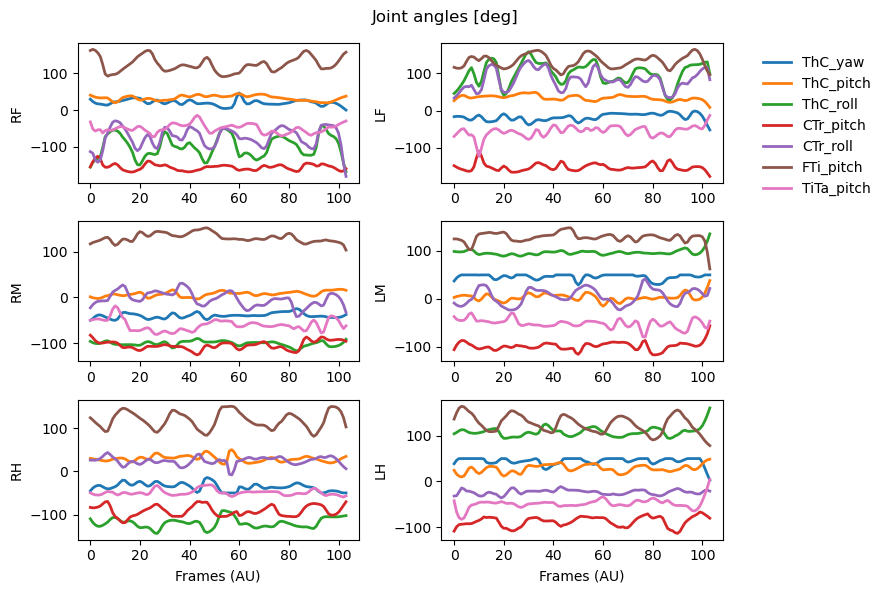

In [24]:
# Let's plot the joint angles for all six legs
plt.style.use('default')
fig, axs = plt.subplots(3,2, figsize=(9, 6), dpi=100)

axs = axs.flatten()
for angle_name in ANGLES:
    for i, leg_name in enumerate(['RF', 'LF', 'RM', 'LM', 'RH', 'LH']):
        axs[i].plot(
            np.rad2deg(leg_joint_angles[f"Angle_{leg_name}_{angle_name}"]),
            label=angle_name,
            lw=2,
        )


        axs[i].set_ylabel(leg_name)


axs[-1].set_xlabel("Frames (AU)")
axs[-2].set_xlabel("Frames (AU)")

axs[1].legend(bbox_to_anchor=(1.1, 1), frameon=False)

plt.suptitle('Joint angles [deg]')
plt.tight_layout()

# fig.savefig("../results/alljoints_follow_ikpy_left.png", bbox_inches="tight")
plt.show()

## 3D visualization

See scripts for more information.

 2023-10-16 16:32:00,616 - INFO- Making animation...


 2023-10-16 16:32:23,075 - INFO- Animation is saved at ../data/data_flytracker/fk_ik_elev_0_azim_0.mp4
 2023-10-16 16:32:23,164 - INFO- Making animation...
 2023-10-16 16:32:33,172 - INFO- Animation is saved at ../data/data_flytracker/fk_ik_elev_0_azim_90.mp4
 2023-10-16 16:32:33,245 - INFO- Making animation...
 2023-10-16 16:32:42,857 - INFO- Animation is saved at ../data/data_flytracker/fk_ik_elev_90_azim_0.mp4


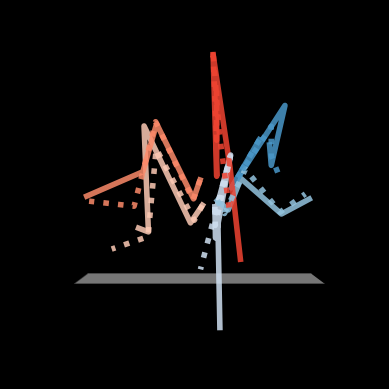

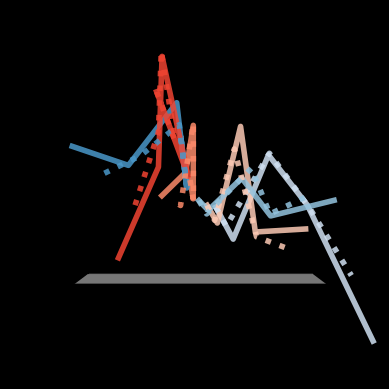

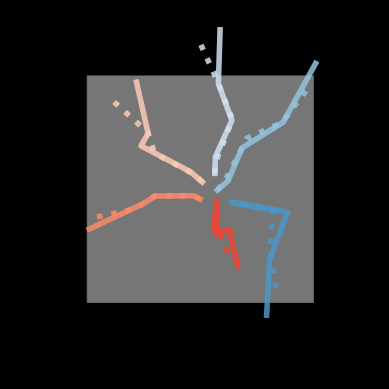

In [12]:
# Files saved automatically after the IK-FK process above.
pose3d = DATA_PATH / "pose3d_aligned.pkl"
forward_kinematics = DATA_PATH / "forward_kinematics.pkl"

with open(pose3d, "rb") as f:
    aligned_pose = pickle.load(f)
with open(forward_kinematics, "rb") as f:
    forward_kin = pickle.load(f)

points_aligned_all = np.concatenate(
    (
        intpd_pose["RF_leg"],
        intpd_pose["RM_leg"],
        intpd_pose["RH_leg"],
        intpd_pose["LF_leg"],
        intpd_pose["LM_leg"],
        intpd_pose["LH_leg"],
    ),
    axis=1,
)

points_fk = np.concatenate(
    (
        forward_kin["RF_leg"],
        forward_kin["RM_leg"],
        forward_kin["RH_leg"],
        forward_kin["LF_leg"],
        forward_kin["LM_leg"],
        forward_kin["LH_leg"],
    ),
    axis=1,
)

for azim, elev in [(0,0),(90,0),(0,90)]:
    animate_3d_points(
        points_aligned_all,
        KEY_POINTS_DICT,
        points3d_second=points_fk,
        key_points_second=KEY_POINTS_DICT2,
        export_path=DATA_PATH / f'fk_ik_elev_{elev}_azim_{azim}.mp4',
        frame_no=points_aligned_all.shape[0],
        elev=elev,
        azim=azim,
        fps=100,
    )


KeyboardInterrupt: 

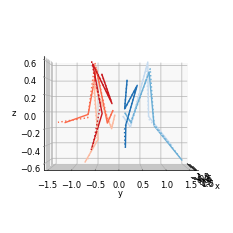

In [13]:
# If wanted, you can save each frame as a png file

plt.style.use('default')

for t in range(points_aligned_all.shape[0]):
    for azim, elev in [(0,0),(90,0),(0,90)]:
        fig = plt.figure(dpi=60)
        ax3d = fig.add_subplot(projection='3d')
        ax3d.view_init(azim=azim, elev=elev)

        ax3d.set_xlabel('x')
        ax3d.set_ylabel('y')
        ax3d.set_zlabel('z')

        plot_3d_points(
            ax3d,
            points_aligned_all,
            KEY_POINTS_DICT,
            t=t
        )
        plot_3d_points(
            ax3d,
            points3d=points_fk,
            key_points=KEY_POINTS_DICT2,
            export_path=DATA_PATH / 'fk_ik' / f'azim_{azim}_elev_{elev}_{t}.png',
            t=t
        )
        plt.close()

